# Homework 7

**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 23th, 2018 at 11:00am

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

Name: Christopher Hase

Collaborators: Casey Meehan

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm
from pymc3 import Uniform, Normal, Binomial, Beta, sample, Model, geweke, sample_ppc, summary
from scipy import stats

## Problem 1: Gibbs Sampling On A Bivariate Normal

Let $\mathbf{X}$ be a random variable taking values in $\mathbb{R}^2$. That is, $\mathbf{X}$ is a 2-dimensional vector. Suppose that $\mathbf{X}$ is normally distributed as follows
$$ 
\mathbf{X} \sim \mathcal{N} \left(  
\left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right],
\left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right] \right).
$$ 
That is, the pdf of the distribution of $\mathbf{X}$ is
$$
f_{\mathbf{X}}(\mathbf{x}) = \frac{1}{2\pi\sqrt{\vert \Sigma\vert }}\mathrm{exp}\left\{ - \frac{1}{2} (\mathbf{x} - \mu)^\top \Sigma^{-1} (\mathbf{x} - \mu)\right\}
$$
where $\mu = \left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right]$, $\Sigma = \left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right]$, and $\vert \cdot\vert $ is the matrix determinant operator.

In the following, we will denote the random variable corresponding to the first component of $\mathbf{X}$ by $X_1$ and the second component by $X_2$.

* Write a Gibbs sampler for this distribution by sampling sequentially from the two conditional distributions $f_{X_1\vert X_2}, f_{X_2\vert X_1}$. 
* Choose a thinning parameter, burn-in factor and total number of iterations that allow you to take 10000 non-autocorrelated draws. 
* You must justify your choice of parameters. 

Here are the necessary conditional distributions to perform Gibbs sampling:

$X_1\hspace{0.1cm}|\hspace{0.1cm}X_2\sim\mathcal{N}\Bigg(1+2\cdot0.3\cdot\bigg(\dfrac{X_2-2}{2}\bigg)=0.4+0.3\cdot X_2,\hspace{0.1cm}4\cdot\big(1-0.3^2\big)=3.64\Bigg)$

$\Rightarrow X_1\hspace{0.1cm}|\hspace{0.1cm}X_2=0.4+0.3\cdot X_2+\sqrt{3.64}\cdot Z\hspace{0.2cm}$ where $Z\sim\mathcal{N}(0,1)$

$X_2\hspace{0.1cm}|\hspace{0.1cm}X_1\sim\mathcal{N}\Bigg(2+2\cdot0.3\cdot\bigg(\dfrac{X_1-1}{2}\bigg)=1.7+0.3\cdot X_1,\hspace{0.1cm}4\cdot\big(1-0.3^2\big)=3.64\Bigg)$

$\Rightarrow X_2\hspace{0.1cm}|\hspace{0.1cm}X_1=1.7+0.3\cdot X_1+\sqrt{3.64}\cdot Z\hspace{0.2cm}$ where $Z\sim\mathcal{N}(0,1)$

In [125]:
# drawing from distribution of x1 given x2
def draw_x1_given_x2(x2):
    draw_std_norm = np.random.standard_normal(size=1)
    return 0.4 + 0.3*x2 + np.sqrt(3.64)*draw_std_norm

# drawing from distribution of x2 given x1
def draw_x2_given_x1(x1):
    draw_std_norm = np.random.standard_normal(size=1)
    return 1.7 + 0.3*x1 + np.sqrt(3.64)*draw_std_norm

In [126]:
np.random.seed(1)

# sampling parameters
burnin = [0, 100, 1000]
thinning = [1, 10, 100]

for burnin_param in burnin:
    for thinning_param in thinning:
        
        # number of iterations to get 10000 samples
        total_iter = burnin_param + thinning_param * 10000

        # initialize x2
        x2 = np.random.standard_normal(size=1)

        # to store samples
        kept_samples = np.zeros((10000, 2))

        # do gibbs sampling
        for sample in range(total_iter):
            x1 = draw_x1_given_x2(x2)
            x2 = draw_x2_given_x1(x1)

            # condition to keep a sample
            if sample >= burnin_param and sample % thinning_param == 0:
                kept_samples[int(sample/thinning_param) - burnin_param, 0] = x1
                kept_samples[int(sample/thinning_param) - burnin_param, 1] = x2
                
        print('Burn-in=' + str(burnin_param) + ', Thinning=' + str(thinning_param))
        print('Estimated mean vector: ' + str(np.mean(kept_samples, axis = 0)))
        print('Estimated covariance matrix:\n' + str(np.cov(kept_samples.T, ddof = 1)))
        print()

Burn-in=0, Thinning=1
Estimated mean vector: [ 1.01425591  2.03725939]
Estimated covariance matrix:
[[ 3.92345266  1.11949052]
 [ 1.11949052  3.99817949]]

Burn-in=0, Thinning=10
Estimated mean vector: [ 1.01748249  2.016936  ]
Estimated covariance matrix:
[[ 4.06922629  1.25881541]
 [ 1.25881541  3.92044353]]

Burn-in=0, Thinning=100
Estimated mean vector: [ 0.99388124  2.00578358]
Estimated covariance matrix:
[[ 4.00576077  1.23514848]
 [ 1.23514848  4.03682158]]

Burn-in=100, Thinning=1
Estimated mean vector: [ 1.01526868  2.03031112]
Estimated covariance matrix:
[[ 3.92821415  1.12640282]
 [ 1.12640282  3.94082836]]

Burn-in=100, Thinning=10
Estimated mean vector: [ 0.99962074  2.00719143]
Estimated covariance matrix:
[[ 3.97724513  1.16842545]
 [ 1.16842545  3.97333785]]

Burn-in=100, Thinning=100
Estimated mean vector: [ 1.03440636  1.99791893]
Estimated covariance matrix:
[[ 4.05150688  1.22831052]
 [ 1.22831052  4.02704799]]

Burn-in=1000, Thinning=1
Estimated mean vector: [ 0.

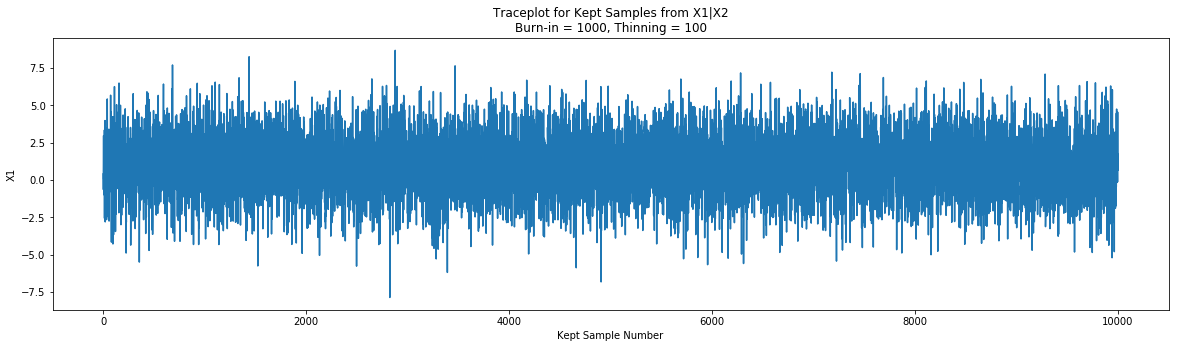

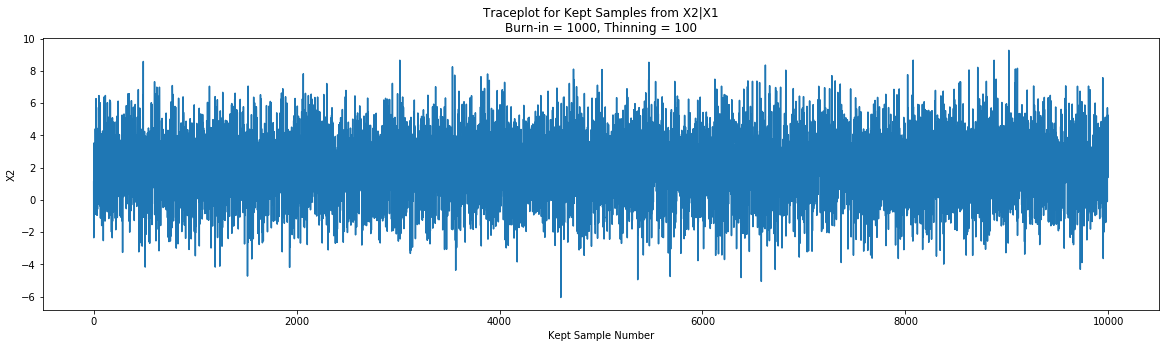

In [6]:
plt.figure(figsize = (20,5))
plt.plot(np.arange(len(kept_samples[:, 0])), kept_samples[:, 0])
plt.xlabel('Kept Sample Number')
plt.ylabel('X1')
plt.title('Traceplot for Kept Samples from X1|X2\nBurn-in = 1000, Thinning = 100')
plt.show()

plt.figure(figsize = (20,5))
plt.plot(np.arange(len(kept_samples[:, 1])), kept_samples[:, 1])
plt.xlabel('Kept Sample Number')
plt.ylabel('X2')
plt.title('Traceplot for Kept Samples from X2|X1\nBurn-in = 1000, Thinning = 100')
plt.show()

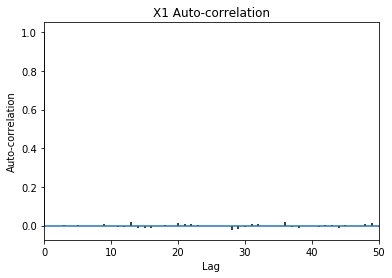

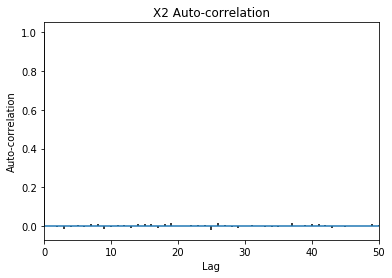

In [127]:
# function to see auto-correlation of X1 or X2
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace), normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])
    
# generate auto-correlation plots
corrplot(kept_samples[:,0])
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.title('X1 Auto-correlation')
plt.show()

corrplot(kept_samples[:,1])
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.title('X2 Auto-correlation')
plt.show()

We would think that the combination of a large burn-in parameter to ensure that the samples that were kept were representative of the desired distribution and that a large thinning parameter to avoid auto-correlated draws from the conditional distributions would yield accurate parameter estimates for the joint distribution. Indeed, the parameter estimates of the joint distributions when using a burn-in parameter of 1000 and a thinning parameter of 100 are pretty accurate. Auto-correlation between kept samples looks low and kept samples from earlier in the chain appear similar to kept samples from later in the chain, providing more justification for this choice of parameters. However, notably, there does not appear to be an obvious relationship between the accuracy of the parameter estimates for the joint distribution and the burn-in and thinning parameters.

## Problem 2: Rubber Chickens Bawk Bawk!
In the competitive rubber chicken retail market, the success of a company is built on satisfying the exacting standards of a consumer base with refined and discriminating taste. In particular, customer product reviews are all important. But how should we judge the quality of a product based on customer reviews?

On Amazon, the first customer review statistic displayed for a product is the ***average rating***. The following are the main product pages for two competing rubber chicken products, manufactured by Lotus World and Toysmith respectively:


Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018spring/homework/lotus1.png) |  ![alt](https://am207.github.io/2018spring/homework/toysmith1.png)

Clicking on the 'customer review' link on the product pages takes us to a detailed break-down of the reviews. In particular, we can now see the number of times a product is rated a given rating (between 1 and 5 stars).

Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018spring/homework/lotus2.png) |  ![alt](https://am207.github.io/2018spring/homework/toysmith2.png)

(The images above are also included on canvas in case you are offline, see below)

In the following, we will ask you to compare these two products using the various rating statistics. **Larger versions of the images are available in the data set accompanying this notebook**.

Suppose that for each product, we can model the probability of the value each new rating as the following vector:
$$
\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]
$$
where $\theta_i$ is the probability that a given customer will give the product $i$ number of stars.


### Part A: Inference

1. Suppose you are told that customer opinions are very polarized in the retail world of rubber chickens, that is, most reviews will be 5 stars or 1 stars (with little middle ground). Choose an appropriate Dirichlet prior for $\theta$. Recall that the Dirichlet pdf is given by:
$$
f_{\Theta}(\theta) = \frac{1}{B(\alpha)} \prod_{i=1}^k \theta_i^{\alpha_i - 1}, \quad B(\alpha) = \frac{\prod_{i=1}^k\Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^k\alpha_i\right)},
$$
where $\theta_i \in (0, 1)$ and $\sum_{i=1}^k \theta_i = 1$, $\alpha_i > 0 $ for $i = 1, \ldots, k$.

2. Write an expression for the posterior pdf, using a using a multinomial model for observed ratings. Recall that the multinomial pdf is given by:
$$
f_{\mathbf{X}\vert  \Theta}(\mathbf{x}) = \frac{n!}{x_1! \ldots x_k!} \theta_1^{x_1} \ldots \theta_k^{x_k}
$$
where $n$ is the total number of trials, $\theta_i$ is the probability of event $i$ and $\sum_i \theta_i = 1$, and $x_i$ is count of outcome $i$ and $\sum_i x_i = n$. 

  **Note:** The data you will need in order to define the likelihood function should be read off the image files included in the dataset.
  

3. Sample 1,000 values of $\theta$ from the *posterior distribution*.
 
4. Sample 1,000 values of $x$ from the *posterior predictive distribution*.


### Part B: Ranking

1. Name at least two major potential problems with using only the average customer ratings to compare products.

  (**Hint:** if product 1 has a higher average rating than product 2, can we conclude that product 1 is better liked? If product 1 and product 2 have the same average rating, can we conclude that they are equally good?)
  

2. Using the samples from your *posterior distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

3. Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

4. Finally, which rubber chicken product is superior?

  (**Note:** we're not looking for "the correct answer" here, any sound decision based on a statistically correct interpretation of your model will be fine)

### Part A.1

Based on the information given, reasonable prior for $\theta$ would be $\theta\sim Dir(10, 1, 1, 1, 10)$

### Part A.2

Let $\mathbf{\tilde{X}}_L$ be the Amazon ratings data for the Loftus World Famous Rubber Chicken.

Let $\mathbf{\tilde{X}}_T$ be the Amazon ratings data for the Toysmith Squawkin' Chicken.

The posterior distribution for $\theta$ will be $\theta\hspace{0.1cm}|\hspace{0.1cm}\mathbf{\tilde{X}}\sim Dir(10+\tilde{x}_1,1+\tilde{x}_2,1+\tilde{x}_3,1+\tilde{x}_4,10+\tilde{x}_5)$

Based on the Amazon ratings data for the Loftus World Famous Rubber Chicken, this turns out to be $\theta\hspace{0.1cm}|\hspace{0.1cm}\mathbf{\tilde{X}}_L\sim Dir(20,7,11,29,118)$

Based on the Amazon ratings data for the Toysmith Squawkin' Chicken, this turns out to be $\theta\hspace{0.1cm}|\hspace{0.1cm}\mathbf{\tilde{X}}_T\sim Dir(67,34,30,46,256)$

The posterior predictive distibution will be $\mathbf{X}\hspace{0.1cm}|\hspace{0.1cm}\mathbf{\tilde{X}}\sim Mult\big(1,E(\theta\hspace{0.1cm}|\hspace{0.1cm}\mathbf{\tilde{X}})\big)\hspace{0.2cm}$where $E(\theta_j\hspace{0.1cm}|\hspace{0.1cm}\mathbf{\tilde{X}})=\dfrac{\theta_j+\tilde{x_j}}{\sum_{i=1}^{5}\theta_i+\tilde{x_i}}\hspace{0.2cm}\forall j\in\{1,2,3,4,5\}$

Based on the Amazon ratings data for the Loftus World Famous Rubber Chicken, this turns out to be $\mathbf{X}\hspace{0.1cm}|\hspace{0.1cm}\mathbf{\tilde{X}}_L\sim Mult\big(1,(0.108,0.0378,0.0595,0.157,0.634)\big)$

Based on the Amazon ratings data for the Toysmith Squawkin' Chicken, this turns out to be $\mathbf{X}\hspace{0.1cm}|\hspace{0.1cm}\mathbf{\tilde{X}}_T\sim Mult\big(1,(0.155,0.0785,0.0693,0.106,0.591)\big)$

In [8]:
# sample from the posterior for theta
def sample_posterior(num_samples, prior_vec, data_vec):
    return np.random.dirichlet(prior_vec + data_vec, size = num_samples)

# sample from the posterior predictive distribution
def sample_posterior_predictive(num_samples, prior_vec, data_vec):
    expectation_theta = (prior_vec + data_vec)/np.sum(prior_vec + data_vec)
    return np.random.choice([1, 2, 3, 4, 5], size = num_samples, replace = True, p = expectation_theta)

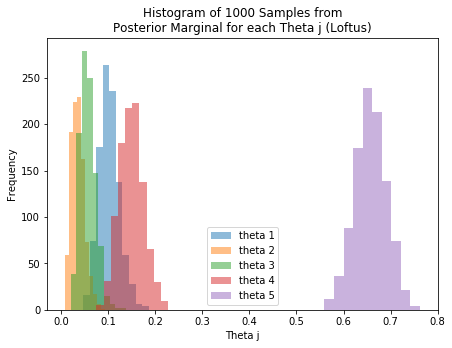

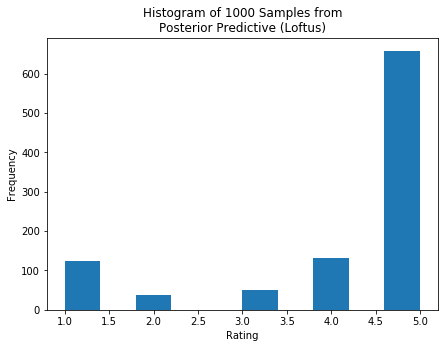

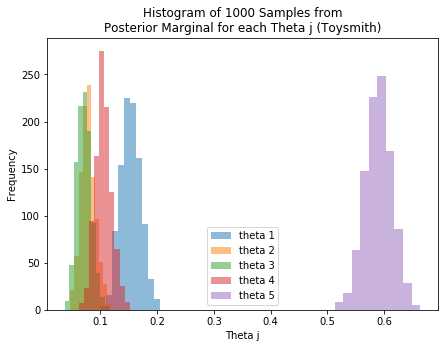

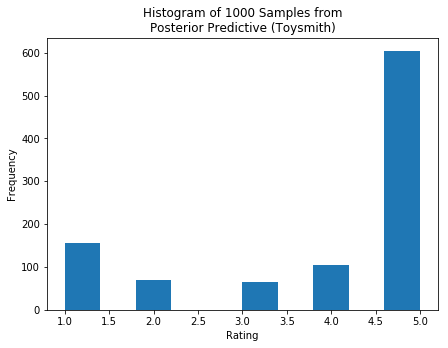

In [9]:
np.random.seed(1)

# amazon ratings data
loftus_data = np.array([10, 6, 10, 28, 118])
toysmith_data = np.array([57, 33, 30, 45, 246])

# prior parameters for theta
theta_prior = np.array([10, 1, 1, 1, 10])

# plot marginals for theta posterior computed using loftus data
num_samples = 1000
posterior_samples_loftus = sample_posterior(num_samples, theta_prior, loftus_data)
plt.figure(figsize=(7,5))
for i in range(5):
    plt.hist(posterior_samples_loftus[:, i], alpha = 0.5)
plt.title('Histogram of 1000 Samples from\nPosterior Marginal for each Theta j (Loftus)')
plt.xlabel('Theta j')
plt.ylabel('Frequency')
plt.legend(loc = 'best', labels = ['theta 1', 'theta 2', 'theta 3', 'theta 4', 'theta 5'])
plt.show()

# plot samples from posterior predictive computed using loftus data
posterior_predictive_samples_loftus = sample_posterior_predictive(1000, theta_prior, loftus_data)
plt.figure(figsize=(7,5))
plt.hist(posterior_predictive_samples_loftus)
plt.title('Histogram of 1000 Samples from\nPosterior Predictive (Loftus)')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()



# plot marginals for theta posterior computed using toysmith data
posterior_samples_toysmith = sample_posterior(num_samples, theta_prior, toysmith_data)
plt.figure(figsize=(7,5))
for i in range(5):
    plt.hist(posterior_samples_toysmith[:, i], alpha = 0.5)

plt.title('Histogram of 1000 Samples from\nPosterior Marginal for each Theta j (Toysmith)')
plt.xlabel('Theta j')
plt.ylabel('Frequency')
plt.legend(loc = 'best', labels = ['theta 1', 'theta 2', 'theta 3', 'theta 4', 'theta 5'])
plt.show()

# plot samples from posterior predictive computed using toysmith data
posterior_predictive_samples_toysmith = sample_posterior_predictive(1000, theta_prior, toysmith_data)
plt.figure(figsize=(7,5))
plt.hist(posterior_predictive_samples_toysmith)
plt.title('Histogram of 1000 Samples from\nPosterior Predictive (Toysmith)')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

### Part B.1.1

If we only use the means of customer ratings to compare products, then we are effectively saying that the goodness of each product can be fully represented by one number. We are not taking into consideration the distributions of the customer ratings. Also, when only using means, we are not accounting for the sample size that produced those means. If a product has one rating that is a 5 and some other product has a large number of ratings that are a mix of 4s and 5s, we wouldn't believe that the product with one rating is better.

### Part B.1.2

In [175]:
# posterior mean theta_1 for loftus vs. toysmith
for i in range(5):
    print('Posterior mean for theta ' + str(i+1) + ' computed using 1000 samples from posterior distribution for theta')
    print('Loftus: ' + str(np.mean(posterior_samples_loftus[:, i])))
    print('Toysmith: ' + str(np.mean(posterior_samples_toysmith[:, i])))
    print()

Posterior mean for theta 1 computed using 1000 samples from posterior distribution for theta
Loftus: 0.101864844288
Toysmith: 0.154379954113

Posterior mean for theta 2 computed using 1000 samples from posterior distribution for theta
Loftus: 0.0353335560195
Toysmith: 0.0782616950136

Posterior mean for theta 3 computed using 1000 samples from posterior distribution for theta
Loftus: 0.0565111757897
Toysmith: 0.0714018301524

Posterior mean for theta 4 computed using 1000 samples from posterior distribution for theta
Loftus: 0.148969965238
Toysmith: 0.105671968372

Posterior mean for theta 5 computed using 1000 samples from posterior distribution for theta
Loftus: 0.657320458665
Toysmith: 0.590284552349



The posterior mean for $\theta_1$ is higher when using the Toysmith ratings than when using the Loftus ratings. The posterior mean for $\theta_2$ is higher when using the Toysmith ratings than when using the Loftus ratings. The posterior mean for $\theta_3$ is higher when using the Toysmith ratings than when using the Loftus ratings. The posterior mean for $\theta_4$ is higher when using the Loftus ratings than when using the Toysmith ratings. The posterior mean for $\theta_5$ is higher when using the Loftus ratings than when using the Toysmith ratings. Altogether, these results indicate that the Loftus World Famous Rubber Chicken is a better product than the Toysmith Squawkin' Chicken.

### Part B.2

In [10]:
# posterior mean theta_1 for loftus vs. toysmith
for i in range(5):
    print('Number of ratings of value ' + str(i+1) + ' out of 1000 samples from posterior predictive distribution')
    print('Loftus: ' + str(np.unique(posterior_predictive_samples_loftus, return_counts = True)[1][i]))
    print('Toysmith: ' + str(np.unique(posterior_predictive_samples_toysmith, return_counts = True)[1][i]))
    print()

Number of ratings of value 1 out of 1000 samples from posterior predictive distribution
Loftus: 124
Toysmith: 156

Number of ratings of value 2 out of 1000 samples from posterior predictive distribution
Loftus: 37
Toysmith: 70

Number of ratings of value 3 out of 1000 samples from posterior predictive distribution
Loftus: 50
Toysmith: 66

Number of ratings of value 4 out of 1000 samples from posterior predictive distribution
Loftus: 131
Toysmith: 104

Number of ratings of value 5 out of 1000 samples from posterior predictive distribution
Loftus: 658
Toysmith: 604



There are more ratings of value 1 sampled from the posterior predictive distribution when using the Toysmith ratings than when using the Loftus ratings. There are more ratings of value 2 sampled from the posterior predictive distribution when using the Toysmith ratings than when using the Loftus ratings. There are more ratings of value 3 sampled from the posterior predictive distribution when using the Toysmith ratings than when using the Loftus ratings. There are more ratings of value 4 sampled from the posterior predictive distribution when using the Loftus ratings than when using the Toysmith ratings. There are more ratings of value 5 sampled from the posterior predictive distribution when using the Loftus ratings than when using the Toysmith ratings. Altogether, these results indicate that the Loftus World Famous Rubber Chicken is a better product than the Toysmith Squawkin' Chicken.

### Part B.3

As mentioned previously, both the samples from the posteriors for $\theta$ and the samples from the posterior predictive distributions indicate that the Loftus World Famous Rubber Chicken is a better product than the Toysmith Squawkin' Chicken.

## Problem 3:  Implementing Rat Tumors in pymc3

(it may help to see the bioassay lab to see how to structure pymc3 code, and also the examples from lecture).

Let us try to do full Bayesian inference with PyMC3 for the rat tumor example that we have solved using explicit Gibbs sampling in lab7. Remember that the goal is to estimate $\theta_i$, the probability of developing a tumor in a population of female rats that have not received treatement. 

The posterior for the 70 experiments may be written thus:

$$p( \{\theta_i\}, \alpha, \beta  \vert  Y, \{n_i\}) \propto p(\alpha, \beta) \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta) \prod_{i=1}^{70} Binom(n_i, y_i, \theta_i)$$

Use uniform priors on $[0,1]$ on the alternative variables $\mu$ (the mean of the beta distribution) and $\nu$:

$$\mu = \frac{\alpha}{\alpha+\beta}, \nu = (\alpha+\beta)^{-1/2}$$

You may then write $\alpha$ and $\beta$ as deterministics which depend on $\mu$ and $\nu$.

Here is the data:

In [2]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

In [3]:
# format data
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])

We have $\mu\sim Unif(0,1)$, $\nu\sim Unif(0,1)$, $\theta_i\hspace{0.1cm}|\hspace{0.1cm}\alpha,\beta\sim Beta(\alpha,\beta)$, and $Y_i\hspace{0.1cm}|\hspace{0.1cm}\theta_i\sim Bin(n_i,\theta_i)$

Also, after some algebra, we get $\alpha=\dfrac{\mu}{\nu^2}$ and $\beta=\dfrac{1-\mu}{\nu^2}$

In [4]:
N = tumorn.shape[0]

with Model() as tumor_model:

    # Uniform priors on the mean and variance of the Beta distributions
    mu = Uniform('mu', 0.00001, 1.)
    nu = Uniform('nu', 0.00001, 1.)

    # Calculate alpha and beta as a function of mu and nu
    alpha = pm.Deterministic('alpha', mu/nu**2)
    beta = pm.Deterministic('beta', (1 - mu)/nu**2)
    
    # Priors for each theta
    thetas = Beta('theta', alpha, beta, shape = N)
    
    # Data likelihood
    obs_deaths = Binomial('obs_deaths', n = tumorn, p = thetas, observed = tumory)

In [5]:
with tumor_model:
    step = pm.step_methods.hmc.nuts.NUTS()
    tumor_trace = pm.sampling.sample(draws = 50000, step = step,\
                                     init = 'advi', compute_convergence_checks = True, chains = 2)


You can find the C code in this temporary file: C:\Users\CHRIST~1\AppData\Local\Temp\theano_compilation_error_y1jdw1v3


Exception: ("Compilation failed (return status=1): C:\\Users\\CHRIST~1\\AppData\\Local\\Temp\\ccp8qx2y.s: Assembler messages:\r. C:\\Users\\CHRIST~1\\AppData\\Local\\Temp\\ccp8qx2y.s:1681: Error: no such instruction: `vfnmadd312sd .LC14(%rip),%xmm7,%xmm6'\r. C:\\Users\\CHRIST~1\\AppData\\Local\\Temp\\ccp8qx2y.s:1682: Error: no such instruction: `vfnmadd312sd .LC15(%rip),%xmm7,%xmm6'\r. C:\\Users\\CHRIST~1\\AppData\\Local\\Temp\\ccp8qx2y.s:2039: Error: no such instruction: `vfnmadd312sd .LC14(%rip),%xmm7,%xmm6'\r. C:\\Users\\CHRIST~1\\AppData\\Local\\Temp\\ccp8qx2y.s:2040: Error: no such instruction: `vfnmadd312sd .LC15(%rip),%xmm7,%xmm6'\r. ", '[Elemwise{psi}(alpha)]')

### Part A:  Report at least the following diagostics on your samples

1. Autocorrelation (correlation dying by lag 20 is fine)
2. Parameter trace correlation after burnin
3. Gewecke
4. Gelman-Rubin
5. $n_{eff}$ (Number of Effective Samples)

### Part A.1

Auto-correlation appears to be low for alpha and beta.

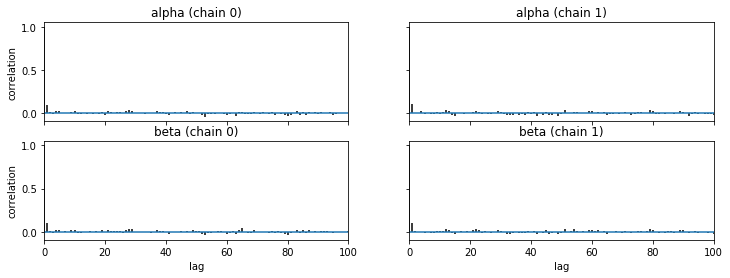

In [40]:
pm.autocorrplot(tumor_trace[1000::10], varnames=['alpha', 'beta'])
plt.show()

### Part A.2

In [39]:
df = pm.trace_to_dataframe(tumor_trace[1000::10])
df.corr()

,mu,nu,alpha,beta,theta__0,theta__1,theta__2,theta__3,theta__4,theta__5,...,theta__60,theta__61,theta__62,theta__63,theta__64,theta__65,theta__66,theta__67,theta__68,theta__69
mu,1.000000,0.171204,0.111689,-0.163355,0.085020,0.102947,0.097569,0.105471,0.097605,0.085561,...,0.099978,0.095404,0.092213,0.085361,0.111902,0.097673,0.092253,0.079831,0.081518,0.105576
nu,0.171204,1.000000,-0.886034,-0.922741,-0.255387,-0.262312,-0.258131,-0.263730,-0.268010,-0.267195,...,0.156580,0.139133,0.152812,0.202795,0.176823,0.191473,0.190393,0.203890,0.215470,0.265487
alpha,0.111689,-0.886034,1.000000,0.956794,0.280282,0.285534,0.286586,0.289012,0.285745,0.281939,...,-0.125172,-0.112785,-0.127488,-0.172248,-0.147624,-0.161783,-0.171282,-0.190833,-0.195507,-0.232403
beta,-0.163355,-0.922741,0.956794,1.000000,0.252848,0.252912,0.253658,0.254314,0.253387,0.254419,...,-0.154336,-0.139283,-0.154521,-0.197560,-0.178825,-0.191481,-0.197914,-0.213785,-0.218307,-0.261817
theta__0,0.085020,-0.255387,0.280282,0.252848,1.000000,0.076744,0.089310,0.094335,0.090761,0.073109,...,-0.042386,-0.028344,-0.010255,-0.038332,-0.023572,-0.030453,-0.013905,-0.041864,-0.036359,-0.064160
theta__1,0.102947,-0.262312,0.285534,0.252912,0.076744,1.000000,0.081984,0.071711,0.105503,0.098561,...,-0.045137,-0.025024,-0.026658,-0.052697,-0.021006,-0.044358,-0.048193,-0.043779,-0.063002,-0.065476
theta__2,0.097569,-0.258131,0.286586,0.253658,0.089310,0.081984,1.000000,0.094208,0.109892,0.076477,...,-0.048307,-0.028640,-0.016292,-0.051306,-0.038318,-0.018227,-0.049476,-0.046276,-0.039230,-0.063957
theta__3,0.105471,-0.263730,0.289012,0.254314,0.094335,0.071711,0.094208,1.000000,0.096988,0.089094,...,-0.042084,-0.023180,-0.042212,-0.041975,-0.040421,-0.037080,-0.046343,-0.058931,-0.069062,-0.068319
theta__4,0.097605,-0.268010,0.285745,0.253387,0.090761,0.105503,0.109892,0.096988,1.000000,0.080512,...,-0.024387,-0.028108,-0.034255,-0.050019,-0.034988,-0.043662,-0.038725,-0.049979,-0.041329,-0.061273
theta__5,0.085561,-0.267195,0.281939,0.254419,0.073109,0.098561,0.076477,0.089094,0.080512,1.000000,...,-0.035151,-0.036707,-0.050320,-0.058688,-0.032088,-0.044846,-0.039488,-0.032797,-0.053671,-0.067463


### Part A.3

Geweke scores close to 0 indicate convergence.

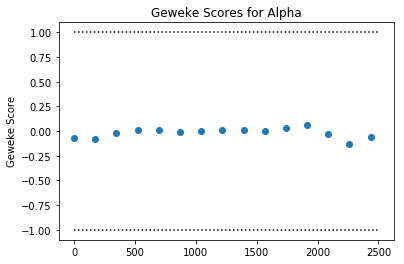

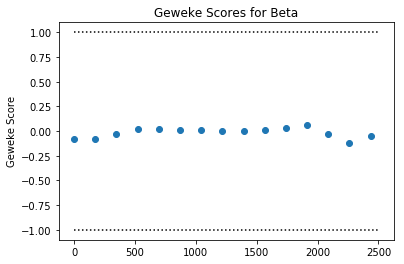

In [128]:
z = geweke(tumor_trace[1000::10], intervals=15)

plt.scatter(z[0]['alpha'][:,0], z[0]['alpha'][:,1])
plt.hlines([-1,1], 0, 2500, linestyles='dotted')
plt.title('Geweke Scores for Alpha')
plt.ylabel('Geweke Score')
plt.show()

plt.scatter(z[0]['beta'][:,0], z[0]['beta'][:,1])
plt.hlines([-1,1], 0, 2500, linestyles='dotted')
plt.title('Geweke Scores for Beta')
plt.ylabel('Geweke Score')
plt.show()

### Part A.4

Gelman-Rubin values close to 1 indicate convergence.

In [64]:
summary(tumor_trace[1000::10])['Rhat']

mu           0.999898
nu           0.999899
alpha        0.999930
beta         0.999907
theta__0     0.999935
theta__1     1.000087
theta__2     1.000021
theta__3     0.999907
theta__4     0.999909
theta__5     0.999956
theta__6     1.000009
theta__7     0.999924
theta__8     0.999899
theta__9     0.999898
theta__10    1.000069
theta__11    0.999899
theta__12    0.999976
theta__13    0.999899
theta__14    0.999902
theta__15    0.999904
theta__16    0.999923
theta__17    0.999915
theta__18    1.000004
theta__19    1.000016
theta__20    0.999953
theta__21    0.999898
theta__22    0.999906
theta__23    0.999901
theta__24    0.999955
theta__25    0.999946
               ...   
theta__40    0.999935
theta__41    0.999948
theta__42    0.999925
theta__43    1.000085
theta__44    0.999993
theta__45    0.999907
theta__46    1.000124
theta__47    0.999903
theta__48    0.999945
theta__49    1.000200
theta__50    0.999898
theta__51    0.999901
theta__52    1.000105
theta__53    0.999943
theta__54 

### Part A.5 

With the chosen burn-in and thinning parmeters, the closer the number of effective samples is to 9800, the better, as this is an indication of lack of auto-correlation.

In [65]:
summary(tumor_trace[1000::10])['n_eff']

mu           9800.0
nu           8253.0
alpha        7652.0
beta         7858.0
theta__0     9800.0
theta__1     7696.0
theta__2     8813.0
theta__3     9615.0
theta__4     9761.0
theta__5     9800.0
theta__6     9488.0
theta__7     9800.0
theta__8     9423.0
theta__9     9792.0
theta__10    9800.0
theta__11    9597.0
theta__12    8961.0
theta__13    9800.0
theta__14    9795.0
theta__15    9800.0
theta__16    9800.0
theta__17    9442.0
theta__18    9800.0
theta__19    9642.0
theta__20    9776.0
theta__21    9800.0
theta__22    9800.0
theta__23    9800.0
theta__24    9800.0
theta__25    8530.0
              ...  
theta__40    9800.0
theta__41    9646.0
theta__42    9714.0
theta__43    9800.0
theta__44    9383.0
theta__45    9785.0
theta__46    9800.0
theta__47    9715.0
theta__48    9556.0
theta__49    9591.0
theta__50    8821.0
theta__51    9798.0
theta__52    9800.0
theta__53    9762.0
theta__54    9800.0
theta__55    9800.0
theta__56    9800.0
theta__57    9082.0
theta__58    9607.0


### Part B:  Posterior predictive check

Recall from lab notes that in a hierarchical model there are two kinds of posterior predictions that are useful. (1) The distribution of future observations $y_i^*$  given a $\theta_i$, and (2) The distribution of observations $y_j^*$  drawn from a future $\theta_j$ drawn from the super-population (i.e. using the Beta on the estimated hyper parameters).

1. Carry out posterior predictive checks by using `sample_ppc` to generate posterior-predictives for all 70 experiments. This generates predictives of the first type above. 

2. Plot histograms for these predictives with the actual value shown as a red-dot against the histogram (as in the coal disasters model in lecture 14). Is the data consistent with the predictive?

### Part B.1

In [70]:
with tumor_model:
    tumor_sim = sample_ppc(tumor_trace[1000::10], samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1673.30it/s]


### Part B.2

The observed numbers of deaths appear to be qualitatively consistent with the posterior predictives.

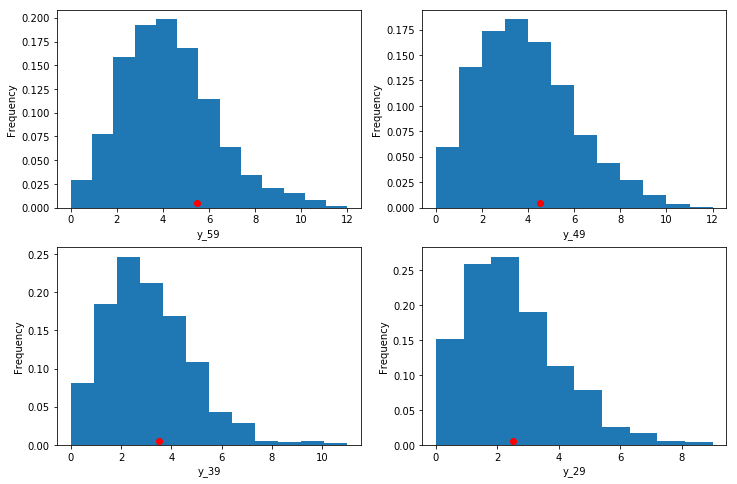

In [211]:
fig = plt.subplots(2, 2, figsize=(12, 8))
plt.subplot(2,2,1)
plt.hist(tumor_sim['obs_deaths'].T[59], density = True, bins = len(np.unique(tumor_sim['obs_deaths'].T[59])))
plt.plot(tumory[59]+0.5, 0.005, 'ro')
plt.xlabel('y_59')
plt.ylabel('Frequency')
plt.subplot(2,2,2)
plt.hist(tumor_sim['obs_deaths'].T[49], density = True, bins = len(np.unique(tumor_sim['obs_deaths'].T[49])))
plt.plot(tumory[49]+0.5, 0.005, 'ro')
plt.xlabel('y_49')
plt.ylabel('Frequency')
plt.subplot(2,2,3)
plt.hist(tumor_sim['obs_deaths'].T[39], density = True, bins = len(np.unique(tumor_sim['obs_deaths'].T[39])))
plt.plot(tumory[39]+0.5, 0.005, 'ro')
plt.xlabel('y_39')
plt.ylabel('Frequency')
plt.subplot(2,2,4)
plt.hist(tumor_sim['obs_deaths'].T[29], density = True, bins = len(np.unique(tumor_sim['obs_deaths'].T[29])))
plt.plot(tumory[29]+0.5, 0.005, 'ro')
plt.xlabel('y_29')
plt.ylabel('Frequency')
plt.show()

### Part C:  Shrinkage

1. Plot the posterior median of the death rate parameters $\theta_1, \theta_2, ...\theta_{70}$ against the observed death rates ($y_i/n_i$)

2. Explain the shrinkage by comparing against a 45 degree line as done in the lab.

### Part C.1

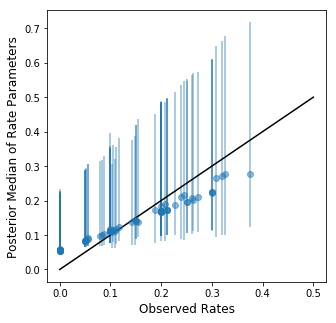

In [96]:
df_sum = summary(tumor_trace[1000::10], varnames=['theta'])

percentiles=np.percentile(tumor_trace[1000::10]['theta'], [2.5,50.0, 97.5], axis=0)
lowerthetas, medianthetas, upperthetas=percentiles

elowertheta = medianthetas - lowerthetas
euppertheta = upperthetas - medianthetas

ratios=tumory.astype(float)/tumorn
plt.figure(figsize=(5,5))
plt.errorbar(ratios, medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("Observed Rates",size=12)
plt.ylabel("Posterior Median of Rate Parameters",size=12)
plt.show()

### Part C.2

When observed rates are low, the posterior median rates are higher than the observed rates. When observed rates are high, the posterior median rates are lower than the observed rates. This makes sense - the priors are acting as regularizers and result in estimates that are not as extreme as the observed values.

### PART D:  Experiment 71

Consider an additional experiment -- experiment 71 -- in which 4 out of 14 rats died. 

1. Calculate the marginal posterior of $\theta_{71}$, the "new" experiment,

2. Find the $y_{71}^*$ posterior predictive for that experiment.

**HINT: ** The critical thing to notice is that the posterior including the 71st experiment factorizes:

$$p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)  \propto p(y_{71} \vert n_{71}, \theta_{71} ) p(\theta_{71} \vert \alpha, \beta) p(\theta_{1..70}, \alpha, \beta \vert  D)$$

Then we simply marginalize over everything to get the $\theta_{71}$ posterior:

$$p(\theta_{71} \vert \theta_{1..70}, \alpha, \beta, D) = \int d\alpha \,d\beta \,d\theta_{1..70} \,p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)$$

$$=  \int d\alpha \,d\beta  Beta(\alpha+y_{71}, \beta + n_{71} - y_{71})  \int_{\theta_{1..70}} \,d\theta_{1..70} \,p(\theta_{1..70}, \alpha, \beta \vert  D)$$

The $y_{71}^*$ posterior predictive can be found in the usual way.

### Part D.1

In [141]:
N = tumorn.shape[0]

with Model() as tumor_model_new:

    # Uniform priors on the mean and variance of the Beta distributions
    mu_new = Uniform('mu_new', 0.00001 , 1)
    nu_new = Uniform('nu_new', 0.00001, 1)

    # Calculate alpha and beta as a function of mu and nu
    alpha_new = pm.Deterministic('alpha_new', mu_new/nu_new**2)
    beta_new = pm.Deterministic('beta_new', (1 - mu_new)/nu_new**2)
    
    # Priors for each theta
    thetas_new = Beta('theta_new', alpha_new, beta_new, shape = N+1)
    
    # Data likelihood
    obs_deaths_new = Binomial('obs_deaths_new', n = np.concatenate((tumorn,np.array([14])),axis=0), 
                          p=thetas_new, observed = np.concatenate((tumory,np.array([4])),axis=0))

In [142]:
with tumor_model_new:
    step = pm.step_methods.hmc.nuts.NUTS()
    tumor_trace_new = pm.sampling.sample(draws = 50000, step = step,\
                                     init = 'advi', compute_convergence_checks = True, chains = 2)

Sequential sampling (2 chains in 1 job)
NUTS: [theta_new_logodds__, nu_new_interval__, mu_new_interval__]
100%|██████████| 50500/50500 [06:34<00:00, 128.07it/s]
The number of effective samples is smaller than 25% for some parameters.


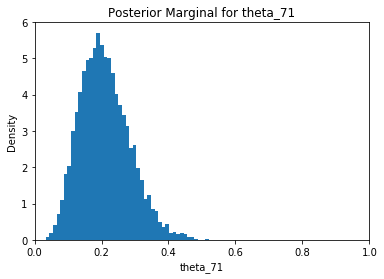

In [147]:
# plot posterior marginal for theta_71
plt.hist(tumor_trace_new['theta_new'][1000::10, 70], density = True, bins = 50)
plt.title('Posterior Marginal for theta_71')
plt.xlabel('theta_71')
plt.ylabel('Density')
plt.xlim([0, 1])
plt.show()

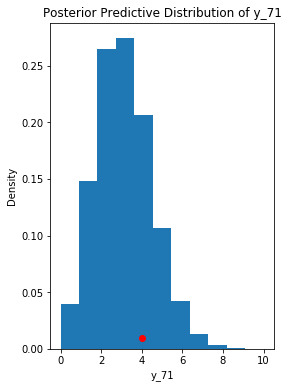

In [212]:
theta_71_posterior_mean = summary(tumor_trace_new)['mean'][-1]

num_draws = 50000
post_pred_y71 = np.zeros(num_draws)
for i in range(num_draws):
    post_pred_y71[i] = np.random.binomial(14, theta_71_posterior_mean, size=1)

# Show posterior predictive distribution for y71
plt.figure(figsize=(4, 6))
plt.hist(post_pred_y71, density = True, bins = len(np.unique(post_pred_y71)))
plt.title('Posterior Predictive Distribution of y_71')
plt.xlabel('y_71')
plt.ylabel('Density')
plt.plot(4, 0.01, 'ro')
plt.show()